In [1]:
import random

In [2]:
import network_components as nc

## Run Neural Network

#### Define test data

In [3]:
xs = [[random.randint(0, 9) for _ in range(3)] for _ in range(500)]
ys = [[4 * x[0] + x[1] + x[2]] for x in xs]

In [4]:
from itertools import cycle

in_cycle = cycle(xs)
target_cycle = cycle(ys)

#### Run epochs

In [5]:
LEARNING_RATE = 0.0001

In [6]:
num_epochs = 500
weights, biases = nc.init_NN(3, 3, 3, 1)
losses = []
for i in range(num_epochs):
    x = next(in_cycle)
    target = next(target_cycle)
    _out = nc.forward(x, weights, biases)
    loss = nc.MSE(_out[-1], target)
    losses.append(loss)
    weights, biases = nc.backprop(weights, biases, _out, target, nc.MSE, LEARNING_RATE)
    if i % (num_epochs // 20) == 0:
        print(loss)
    if loss < 1e-10:
        break
weights

68.9539963819156
28.118780349373175
51.6796819880444
35.958470237011305
4.812554674957111
14.225645346445894
0.01203587210459697
4.375964650786142
3.2512284377612577
0.17708793822550317
0.0572771271489206
0.03140077137884072
1.6832904568640905
0.285975040978964
0.5156790512621797
0.7527240389711581
0.08298553761893927
0.01158261447488811
0.4063044056856794
0.05266414586516987


[[[0.7768652203601641, 0.03608835886178436, 0.28111803460201823],
  [0.4572082660037724, 0.3540388416527597, 0.26130014254303136],
  [1.4378408040234185, 0.38926525047354704, 0.2023151705426649]],
 [[0.3759841507571494, 0.4299906399620904, 0.9905078387395401],
  [0.7702019074210704, 0.0018329324576855338, 0.9684691023658153],
  [0.7853495608219598, 0.07559980177786207, 0.3909206497386258]],
 [[0.912404980796733, 0.7333578985655398, 0.5295261371421884]]]

In [7]:
import matplotlib.pyplot as plt

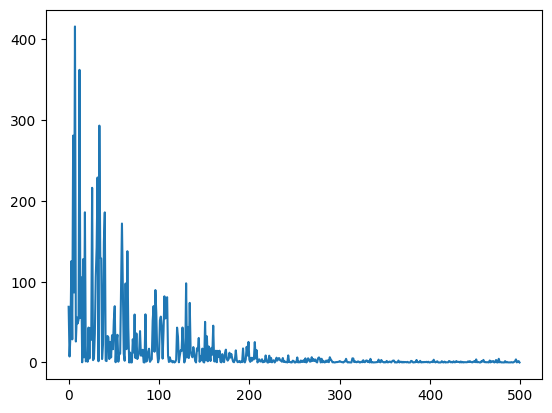

In [8]:
plt.plot(range(len(losses)), losses)